### DYNAMICS, EVT & DAMAGE (Rainfall, Bias Correction, EVT, Hazard Scaling)

In [1]:
import xarray as xr 
import pandas as pd 
import numpy as np 


In [2]:
imd=xr.open_dataset('/vol/sandeep_storage/Files2/catastrophe/imd_rainfall/RF25_ind2018_rfp25.nc')
imd


<xarray.Dataset> Size: 51MB
Dimensions:    (LONGITUDE: 135, LATITUDE: 129, TIME: 365)
Coordinates:
  * LONGITUDE  (LONGITUDE) float64 1kB 66.5 66.75 67.0 ... 99.5 99.75 100.0
  * LATITUDE   (LATITUDE) float64 1kB 6.5 6.75 7.0 7.25 ... 38.0 38.25 38.5
  * TIME       (TIME) datetime64[ns] 3kB 2018-01-01 2018-01-02 ... 2018-12-31
Data variables:
    RAINFALL   (TIME, LATITUDE, LONGITUDE) float64 51MB ...
Attributes:
    history:      FERRET V7.5 (optimized) 20-Jan-23
    Conventions:  CF-1.6

#### bias correction

In [3]:
import pandas as pd
import numpy as np
import xarray as xr
import geopandas as gpd
from scipy import stats
from pathlib import Path


In [4]:
basin = gpd.read_file(
    "/vol/sandeep_storage/Files2/catastrophe/hydrobasin_08/musi_basin.shp"
).to_crs(epsg=4326)

minx, miny, maxx, maxy = basin.total_bounds


In [5]:
era5 = pd.read_parquet(
    "/vol/sandeep_storage/Files2/catastrophe/"
    "era5_catastrophe_daily_full_2010_2024.parquet"
)

# Clip spatially to Musi bounding box
era5 = era5[
    (era5["longitude"] >= minx) &
    (era5["longitude"] <= maxx) &
    (era5["latitude"]  >= miny) &
    (era5["latitude"]  <= maxy)
]

# Basin-mean daily rainfall
era5_daily = (
    era5.groupby("valid_time")["tp_total_mm"]
    .mean()
    .rename("era5_mm")
    .to_frame()
)

print("ERA5 period:", era5_daily.index.min(), "→", era5_daily.index.max())


ERA5 period: 2010-01-01 00:00:00 → 2024-12-31 00:00:00


In [7]:
imd_series = []

for year in range(2010, 2024):
    fpath = Path(
        f"/vol/sandeep_storage/Files2/catastrophe/imd_rainfall/"
        f"RF25_ind{year}_rfp25.nc"
    )
    
    if not fpath.exists():
        continue

    ds = xr.open_dataset(fpath)

    # Spatial clip
    ds = ds.sel(
        LONGITUDE=slice(minx, maxx),
        LATITUDE=slice(miny, maxy)
    )

    # Basin-mean daily rainfall
    imd_daily = (
        ds["RAINFALL"]
        .mean(dim=["LATITUDE", "LONGITUDE"])
        .to_dataframe()
        .rename(columns={"RAINFALL": "imd_mm"})
    )

    imd_series.append(imd_daily)

imd_daily = pd.concat(imd_series)
imd_daily.index = pd.to_datetime(imd_daily.index)

print("IMD period:", imd_daily.index.min(), "→", imd_daily.index.max())


IMD period: 2010-01-01 00:00:00 → 2023-12-31 00:00:00


In [8]:
df = era5_daily.join(imd_daily, how="inner").dropna()

print("Aligned days:", len(df))
print(df.describe())


Aligned days: 5113
           era5_mm       imd_mm
count  5113.000000  5113.000000
mean      2.434154     2.353937
std       6.480659     7.433932
min       0.000000     0.000000
25%       0.000000     0.000000
50%       0.087857     0.000000
75%       1.486659     0.667913
max     107.922318   201.017239


In [9]:
def quantile_mapping(sim, obs):
    """
    Non-parametric Quantile Mapping
    """
    sim_sorted = np.sort(sim)
    obs_sorted = np.sort(obs)

    # Empirical CDF of simulated
    cdf_sim = stats.rankdata(sim, method="average") / (len(sim) + 1)

    # Map to observed quantiles
    corrected = np.interp(
        cdf_sim,
        np.linspace(0, 1, len(obs_sorted)),
        obs_sorted
    )

    return corrected


In [10]:
df["era5_mm_bc"] = quantile_mapping(
    df["era5_mm"].values,
    df["imd_mm"].values
)

# Safety: no negative rainfall
df["era5_mm_bc"] = df["era5_mm_bc"].clip(lower=0)


In [11]:
print("\n--- BEFORE (ERA5) ---")
print(df["era5_mm"].quantile([0.5, 0.9, 0.99]))

print("\n--- IMD (OBS) ---")
print(df["imd_mm"].quantile([0.5, 0.9, 0.99]))

print("\n--- AFTER (ERA5 BC) ---")
print(df["era5_mm_bc"].quantile([0.5, 0.9, 0.99]))



--- BEFORE (ERA5) ---
0.50     0.087857
0.90     7.516885
0.99    29.755817
Name: era5_mm, dtype: float64

--- IMD (OBS) ---
0.50     0.000000
0.90     6.871801
0.99    34.649856
Name: imd_mm, dtype: float64

--- AFTER (ERA5 BC) ---
0.50     0.000000
0.90     6.860404
0.99    34.474229
Name: era5_mm_bc, dtype: float64


In [12]:
out_path = (
    "/vol/sandeep_storage/Files2/catastrophe/"
    "era5_musi_bias_corrected_daily.parquet"
)

df.reset_index().to_parquet(out_path)

print("\nSaved bias-corrected ERA5 rainfall:")
print(out_path)



Saved bias-corrected ERA5 rainfall:
/vol/sandeep_storage/Files2/catastrophe/era5_musi_bias_corrected_daily.parquet


In [14]:
corr=pd.read_parquet('/vol/sandeep_storage/Files2/catastrophe/era5_musi_bias_corrected_daily.parquet')
corr


,index,era5_mm,imd_mm,era5_mm_bc
0,2010-01-01,0.000000,0.0,0.0
1,2010-01-02,0.000000,0.0,0.0
2,2010-01-03,0.000000,0.0,0.0
3,2010-01-04,0.000000,0.0,0.0
4,2010-01-05,0.000000,0.0,0.0
...,...,...,...,...
5108,2023-12-27,0.000119,0.0,0.0
5109,2023-12-28,0.000000,0.0,0.0
5110,2023-12-29,0.000000,0.0,0.0
5111,2023-12-30,0.000000,0.0,0.0


In [15]:
import pandas as pd

# ============================================================
# LOAD FILE
# ============================================================

df = pd.read_parquet(
    "/vol/sandeep_storage/Files2/catastrophe/"
    "era5_musi_bias_corrected_daily.parquet"
)

print("Before rename:")
print(df.head())
print(df.dtypes)

# ============================================================
# RENAME COLUMN
# ============================================================

df = df.rename(columns={"index": "valid_time"})

# Ensure datetime
df["valid_time"] = pd.to_datetime(df["valid_time"])

print("\nAfter rename:")
print(df.head())
print(df.dtypes)

# ============================================================
# SAVE BACK (OVERWRITE OR NEW FILE)
# ============================================================

out_path = (
    "/vol/sandeep_storage/Files2/catastrophe/"
    "era5_musi_bias_corrected_daily.parquet"
)

df.to_parquet(out_path, index=False)

print("\nSaved with valid_time column:", out_path)


Before rename:
       index  era5_mm  imd_mm  era5_mm_bc
0 2010-01-01      0.0     0.0         0.0
1 2010-01-02      0.0     0.0         0.0
2 2010-01-03      0.0     0.0         0.0
3 2010-01-04      0.0     0.0         0.0
4 2010-01-05      0.0     0.0         0.0
index         datetime64[ns]
era5_mm              float32
imd_mm               float64
era5_mm_bc           float64
dtype: object

After rename:
  valid_time  era5_mm  imd_mm  era5_mm_bc
0 2010-01-01      0.0     0.0         0.0
1 2010-01-02      0.0     0.0         0.0
2 2010-01-03      0.0     0.0         0.0
3 2010-01-04      0.0     0.0         0.0
4 2010-01-05      0.0     0.0         0.0
valid_time    datetime64[ns]
era5_mm              float32
imd_mm               float64
era5_mm_bc           float64
dtype: object

Saved with valid_time column: /vol/sandeep_storage/Files2/catastrophe/era5_musi_bias_corrected_daily.parquet


Columns: Index(['valid_time', 'era5_mm', 'imd_mm', 'era5_mm_bc'], dtype='object')
Time range: 2010-01-01 00:00:00 → 2023-12-31 00:00:00
Days in 2020: 366

Daily rainfall stats (2020):
count    366.000000
mean       3.063366
std        8.627910
min        0.000000
25%        0.000000
50%        0.000000
75%        1.696532
max      106.115243
Name: era5_mm_bc, dtype: float64


/tmp/ipykernel_270974/3047255489.py:50: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_rain = daily_rain.resample("M").mean()


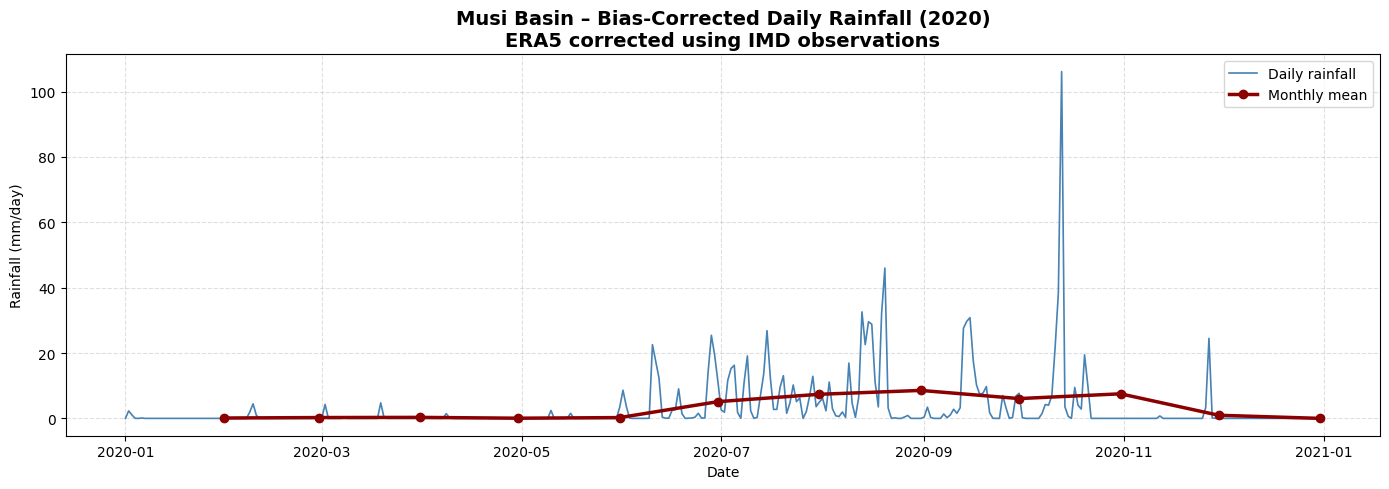

In [16]:
import pandas as pd
import matplotlib.pyplot as plt

# ============================================================
# LOAD BIAS-CORRECTED ERA5 MUSI RAINFALL
# ============================================================

era5_bc = pd.read_parquet(
    "/vol/sandeep_storage/Files2/catastrophe/"
    "era5_musi_bias_corrected_daily.parquet"
)

print("Columns:", era5_bc.columns)
print("Time range:", era5_bc["valid_time"].min(), "→", era5_bc["valid_time"].max())

# ============================================================
# ENSURE DATETIME
# ============================================================

era5_bc["valid_time"] = pd.to_datetime(era5_bc["valid_time"])

# ============================================================
# FILTER YEAR = 2020
# ============================================================

era5_2020 = era5_bc[
    era5_bc["valid_time"].dt.year == 2020
]

print("Days in 2020:", era5_2020["valid_time"].nunique())

# ============================================================
# BASIN-MEAN DAILY RAINFALL
# ============================================================

daily_rain = (
    era5_2020
    .groupby("valid_time")["era5_mm_bc"]
    .mean()
    .sort_index()
)

print("\nDaily rainfall stats (2020):")
print(daily_rain.describe())

# ============================================================
# MONTHLY MEAN (FOR CONTEXT)
# ============================================================

monthly_rain = daily_rain.resample("M").mean()

# ============================================================
# PLOT
# ============================================================

plt.figure(figsize=(14, 5))

plt.plot(
    daily_rain.index,
    daily_rain.values,
    color="steelblue",
    linewidth=1.2,
    label="Daily rainfall"
)

plt.plot(
    monthly_rain.index,
    monthly_rain.values,
    color="darkred",
    linewidth=2.5,
    marker="o",
    label="Monthly mean"
)

plt.xlabel("Date")
plt.ylabel("Rainfall (mm/day)")
plt.title(
    "Musi Basin – Bias-Corrected Daily Rainfall (2020)\n"
    "ERA5 corrected using IMD observations",
    fontsize=14,
    weight="bold"
)

plt.grid(True, linestyle="--", alpha=0.4)
plt.legend()
plt.tight_layout()
plt.show()


In [17]:
df_2020 = df[df["valid_time"].dt.year == 2020]

print(df_2020[["era5_mm", "imd_mm", "era5_mm_bc"]].describe(percentiles=[0.9, 0.95, 0.99]))


          era5_mm      imd_mm  era5_mm_bc
count  366.000000  366.000000  366.000000
mean     3.123508    3.482182    3.063366
std      8.152582   13.005612    8.627910
min      0.000000    0.000000    0.000000
50%      0.118196    0.000000    0.000000
90%      9.950995    9.207713   10.129389
95%     16.768306   19.169600   18.748878
99%     27.808011   41.982039   32.205425
max    107.922318  201.017239  106.115243


#### EVT-AMS

Date range: 2010-01-01 00:00:00 → 2023-12-31 00:00:00

Annual Maxima Summary:
count     14.000000
mean      58.878497
std       22.165018
min       29.820119
25%       44.271165
50%       54.166339
75%       65.846200
max      106.115243
Name: annual_max_mm, dtype: float64

Number of years used for EVT: 14

GEV Parameters:
Location (mu) : 48.47 mm
Scale (sigma) : 15.35 mm
Shape (xi)    : 0.094

EVT Return Levels (Musi Basin):
   return_period_years  rainfall_mm
0                    2    54.193083
1                    5    73.203543
2                   10    86.953951
3                   25   105.776606
4                   50   120.867324
5                  100   136.868513

Saved EVT table: /vol/sandeep_storage/Files2/catastrophe/musi_evt_return_levels.csv


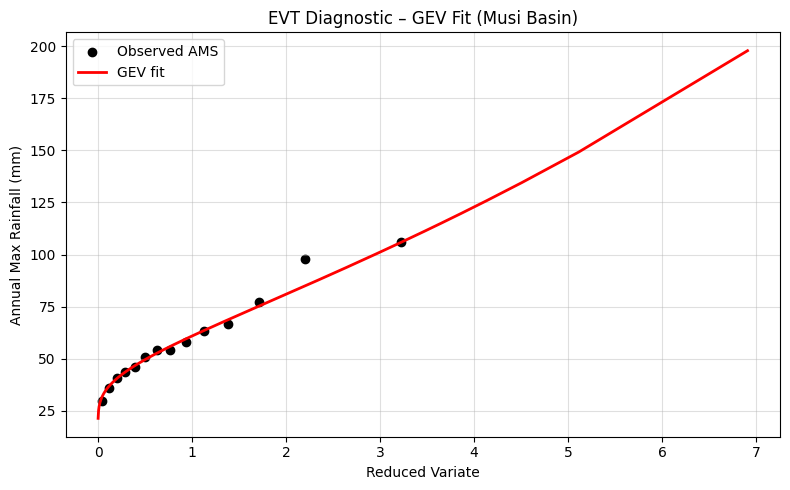

In [53]:
import pandas as pd
import numpy as np
from scipy.stats import genextreme
import matplotlib.pyplot as plt

# ============================================================
# LOAD BIAS-CORRECTED DAILY RAINFALL
# ============================================================

df = pd.read_parquet(
    "/vol/sandeep_storage/Files2/catastrophe/"
    "era5_musi_bias_corrected_daily.parquet"
)

df["valid_time"] = pd.to_datetime(df["valid_time"])
df = df.sort_values("valid_time")

print("Date range:", df["valid_time"].min(), "→", df["valid_time"].max())

# ============================================================
# BUILD ANNUAL MAXIMA SERIES (AMS)
# ============================================================

df["year"] = df["valid_time"].dt.year

ams = (
    df.groupby("year")["era5_mm_bc"]
    .max()
    .reset_index()
    .rename(columns={"era5_mm_bc": "annual_max_mm"})
)

print("\nAnnual Maxima Summary:")
print(ams["annual_max_mm"].describe())

n_years = len(ams)
print(f"\nNumber of years used for EVT: {n_years}")

# ============================================================
# FIT GEV DISTRIBUTION (MLE)
# ============================================================

# SciPy uses shape = -xi
shape, loc, scale = genextreme.fit(ams["annual_max_mm"])

xi = -shape
mu = loc
sigma = scale

print("\nGEV Parameters:")
print(f"Location (mu) : {mu:.2f} mm")
print(f"Scale (sigma) : {sigma:.2f} mm")
print(f"Shape (xi)    : {xi:.3f}")

# ============================================================
# COMPUTE RETURN LEVELS
# ============================================================

return_periods = np.array([2, 5, 10, 25, 50, 100])
prob = 1 - 1 / return_periods

return_levels = genextreme.ppf(prob, shape, loc=loc, scale=scale)

evt_table = pd.DataFrame({
    "return_period_years": return_periods,
    "rainfall_mm": return_levels
})

print("\nEVT Return Levels (Musi Basin):")
print(evt_table)

# ============================================================
# SAVE EVT RESULTS
# ============================================================

evt_out = (
    "/vol/sandeep_storage/Files2/catastrophe/"
    "musi_evt_return_levels.csv"
)
evt_table.to_csv(evt_out, index=False)
print("\nSaved EVT table:", evt_out)

# ============================================================
# DIAGNOSTIC PLOT (VERY IMPORTANT)
# ============================================================

plt.figure(figsize=(8, 5))

sorted_obs = np.sort(ams["annual_max_mm"])
#empirical_prob = np.arange(1, len(sorted_obs)+1) / (len(sorted_obs)+1)
empirical_prob = (np.arange(1, len(sorted_obs)+1) - 0.44) / (len(sorted_obs) + 0.12)


plt.scatter(
    -np.log(1 - empirical_prob),
    sorted_obs,
    label="Observed AMS",
    color="black"
)

x = np.linspace(0.001, 0.999, 200)
plt.plot(
    -np.log(1 - x),
    genextreme.ppf(x, shape, loc=loc, scale=scale),
    color="red",
    linewidth=2,
    label="GEV fit"
)

plt.xlabel("Reduced Variate")
plt.ylabel("Annual Max Rainfall (mm)")
plt.title("EVT Diagnostic – GEV Fit (Musi Basin)")
plt.legend()
plt.grid(alpha=0.4)

plt.tight_layout()
plt.show()


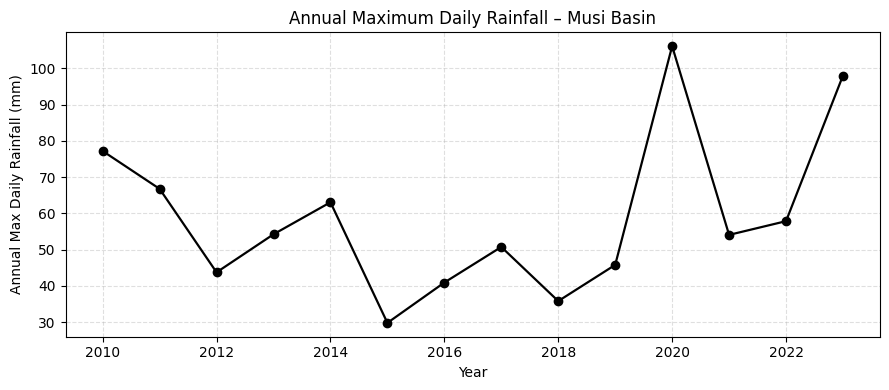

In [54]:
plt.figure(figsize=(9, 4))

plt.plot(
    ams["year"],
    ams["annual_max_mm"],
    marker="o",
    linewidth=1.6,
    color="black"
)

plt.xlabel("Year")
plt.ylabel("Annual Max Daily Rainfall (mm)")
plt.title("Annual Maximum Daily Rainfall – Musi Basin")
plt.grid(True, linestyle="--", alpha=0.4)

plt.tight_layout()
plt.show()


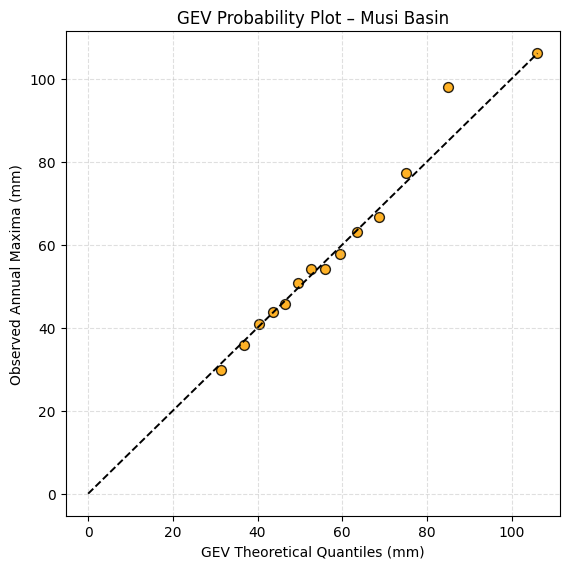

In [55]:
# ============================================================
# GEV PROBABILITY PLOT
# ============================================================

sorted_obs = np.sort(ams["annual_max_mm"].values)
n = len(sorted_obs)

# Gringorten plotting position
p_emp = (np.arange(1, n + 1) - 0.44) / (n + 0.12)

# GEV theoretical quantiles
gev_quant = genextreme.ppf(
    p_emp,
    c=-xi,        # scipy uses shape = -xi
    loc=mu,
    scale=sigma
)

plt.figure(figsize=(5.8, 5.8))

plt.scatter(
    gev_quant,
    sorted_obs,
    s=50,
    edgecolor="black",
    facecolor="orange",
    alpha=0.85
)

# 1:1 reference line
maxv = max(sorted_obs.max(), gev_quant.max())
plt.plot([0, maxv], [0, maxv], "k--", linewidth=1.4)

plt.xlabel("GEV Theoretical Quantiles (mm)")
plt.ylabel("Observed Annual Maxima (mm)")
plt.title("GEV Probability Plot – Musi Basin")
plt.grid(True, linestyle="--", alpha=0.4)

plt.tight_layout()
plt.show()


#### Flood Hazard Index (per return period)

In [56]:
#Create basin-level hazard index
import pandas as pd

# ============================================================
# EVT RETURN LEVELS (FROM YOUR SAVED CSV)
# ============================================================

evt = pd.read_csv(
    "/vol/sandeep_storage/Files2/catastrophe/musi_evt_return_levels.csv"
)

# Extract 100-year rainfall (normalisation anchor)
R100 = evt.loc[evt["return_period_years"] == 100, "rainfall_mm"].values[0]

# ============================================================
# COMPUTE FLOOD HAZARD INDEX
# ============================================================

evt["flood_hazard_index"] = evt["rainfall_mm"] / R100
evt["flood_hazard_index"] = evt["flood_hazard_index"].clip(0, 1)

print(evt)

# Save
evt_out = "/vol/sandeep_storage/Files2/catastrophe/musi_flood_hazard_index.csv"
evt.to_csv(evt_out, index=False)

print("Saved hazard index:", evt_out)


   return_period_years  rainfall_mm  flood_hazard_index
0                    2    54.193083            0.395950
1                    5    73.203543            0.534846
2                   10    86.953951            0.635310
3                   25   105.776606            0.772834
4                   50   120.867324            0.883091
5                  100   136.868513            1.000000
Saved hazard index: /vol/sandeep_storage/Files2/catastrophe/musi_flood_hazard_index.csv


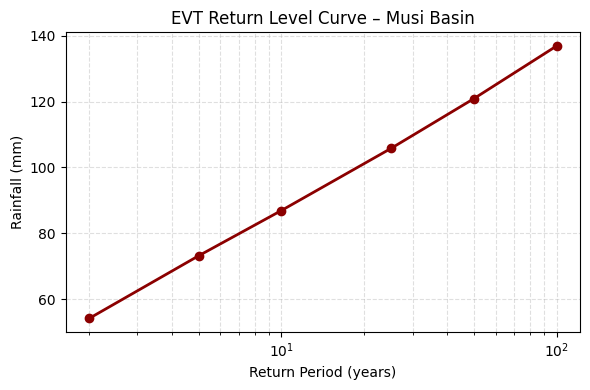

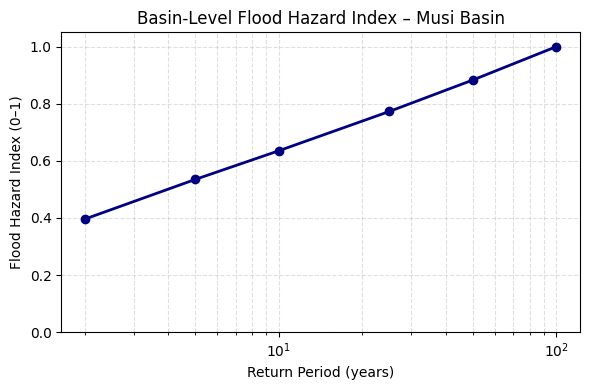

In [57]:
import pandas as pd
import matplotlib.pyplot as plt



# ============================================================
# PLOT 1: EVT RETURN LEVEL CURVE (Rainfall)
# ============================================================

plt.figure(figsize=(6, 4))

plt.plot(
    evt["return_period_years"],
    evt["rainfall_mm"],
    marker="o",
    linewidth=2,
    color="darkred"
)

plt.xscale("log")
plt.xlabel("Return Period (years)")
plt.ylabel("Rainfall (mm)")
plt.title("EVT Return Level Curve – Musi Basin")
plt.grid(True, which="both", linestyle="--", alpha=0.4)

plt.tight_layout()
plt.show()

# ============================================================
# PLOT 2: EVT FLOOD HAZARD INDEX CURVE
# ============================================================

plt.figure(figsize=(6, 4))

plt.plot(
    evt["return_period_years"],
    evt["flood_hazard_index"],
    marker="o",
    linewidth=2,
    color="navy"
)

plt.xscale("log")
plt.ylim(0, 1.05)
plt.xlabel("Return Period (years)")
plt.ylabel("Flood Hazard Index (0–1)")
plt.title("Basin-Level Flood Hazard Index – Musi Basin")
plt.grid(True, which="both", linestyle="--", alpha=0.4)

plt.tight_layout()
plt.show()


In [58]:
import geopandas as gpd
import pandas as pd
import numpy as np

# ============================================================
# LOAD FACILITY STATIC FLOOD HAZARD INDEX
# ============================================================

waste = gpd.read_file(
    "/vol/sandeep_storage/Files2/catastrophe/osm/"
    "waste_facilities_flood_hazard_index.geojson"
).to_crs(epsg=4326)

print("Loaded facilities:", len(waste))

assert "flood_hazard_index" in waste.columns, \
    "Missing flood_hazard_index in facility file!"

# ============================================================
# LOAD EVT-BASED HAZARD SEVERITY CURVE
# ============================================================

evt = pd.read_csv(
    "/vol/sandeep_storage/Files2/catastrophe/"
    "musi_flood_hazard_index.csv"
)

print("\nLoaded EVT hazard curve:")
print(evt)

# ============================================================
# BUILD FACILITY-LEVEL HAZARD SCENARIOS
# ============================================================

for _, row in evt.iterrows():
    rp = int(row["return_period_years"])
    evt_hazard = row["flood_hazard_index"]

    # Facility-level hazard = static × event severity
    waste[f"hazard_{rp}yr"] = (
        waste["flood_hazard_index"] * evt_hazard
    ).clip(0, 1)

# ============================================================
# SANITY CHECK
# ============================================================

haz_cols = [c for c in waste.columns if c.startswith("hazard_")]

print("\nFacility hazard scenario stats:")
print(waste[haz_cols].describe())

# ============================================================
# SAVE FINAL SCENARIO FILE
# ============================================================

out_path = (
    "/vol/sandeep_storage/Files2/catastrophe/osm/"
    "waste_facilities_flood_hazard_scenarios_evt.geojson"
)

waste.to_file(out_path, driver="GeoJSON")

print("\nSaved facility-level EVT hazard scenarios:")
print(out_path)


Loaded facilities: 16

Loaded EVT hazard curve:
   return_period_years  rainfall_mm  flood_hazard_index
0                    2    54.193083            0.395950
1                    5    73.203543            0.534846
2                   10    86.953951            0.635310
3                   25   105.776606            0.772834
4                   50   120.867324            0.883091
5                  100   136.868513            1.000000

Facility hazard scenario stats:
       hazard_2yr  hazard_5yr  hazard_10yr  hazard_25yr  hazard_50yr  \
count   16.000000   16.000000    16.000000    16.000000    16.000000   
mean     0.228804    0.309067     0.367121     0.446591     0.510304   
std      0.052555    0.070991     0.084326     0.102580     0.117214   
min      0.134740    0.182006     0.216193     0.262992     0.300512   
25%      0.205745    0.277918     0.330122     0.401582     0.458874   
50%      0.217790    0.294189     0.349449     0.425094     0.485740   
75%      0.258489    0.

In [59]:
waste


,facility_type,dist_to_drainage_m,vuln_drainage,elevation_m,elev_percentile,vuln_elevation,slope_deg,slope_percentile,vuln_slope,flood_hazard_index,hazard_category,geometry,hazard_2yr,hazard_5yr,hazard_10yr,hazard_25yr,hazard_50yr,hazard_100yr
0,wastewater_plant,1175.916986,0.764817,515.0,0.50000,0.50000,1.238635,0.93750,0.06250,0.531667,Moderate,POINT (78.46435 17.41619),0.210514,0.284360,0.337774,0.410891,0.469511,0.531667
1,wastewater_plant,159.951078,0.968010,502.0,0.25000,0.75000,0.699146,0.46875,0.53125,0.804354,High,POINT (78.53388 17.3818),0.318484,0.430206,0.511014,0.621632,0.710318,0.804354
2,landfill,3187.375573,0.362525,495.0,0.12500,0.87500,0.972854,0.71875,0.28125,0.525636,Moderate,POINT (78.5822 17.35038),0.208126,0.281134,0.333942,0.406229,0.464184,0.525636
3,wastewater_plant,28.441820,0.994312,518.0,0.65625,0.34375,0.718740,0.62500,0.37500,0.642753,High,POINT (78.57735 17.39818),0.254498,0.343774,0.408347,0.496741,0.567609,0.642753
4,transfer_station,168.646433,0.966271,528.0,0.93750,0.06250,0.448432,0.18750,0.81250,0.619197,High,POINT (78.47969 17.41394),0.245171,0.331175,0.393382,0.478536,0.546807,0.619197
5,wastewater_plant,873.892710,0.825221,532.0,1.00000,0.00000,0.000000,0.09375,0.90625,0.552600,Moderate,POINT (78.47197 17.44359),0.218802,0.295556,0.351072,0.427068,0.487996,0.552600
6,wastewater_plant,303.693938,0.939261,526.0,0.87500,0.12500,0.984000,0.81250,0.18750,0.503918,Moderate,POINT (78.47839 17.43744),0.199526,0.269518,0.320144,0.389444,0.445005,0.503918
7,wastewater_plant,1211.262999,0.757747,493.0,0.06250,0.93750,0.972854,0.71875,0.28125,0.725361,High,POINT (78.35948 17.41553),0.287207,0.387956,0.460829,0.560584,0.640560,0.725361
8,wastewater_plant,568.492664,0.886301,525.0,0.81250,0.18750,1.280363,1.00000,0.00000,0.464461,Moderate,POINT (78.5509 17.42333),0.183903,0.248415,0.295077,0.358951,0.410161,0.464461
9,landfill,2460.283916,0.507943,515.0,0.50000,0.50000,0.619390,0.25000,0.75000,0.553574,Moderate,POINT (78.37324 17.45976),0.219188,0.296077,0.351691,0.427821,0.488856,0.553574


#### Facility Hazard vs Return Period (EVT-driven)

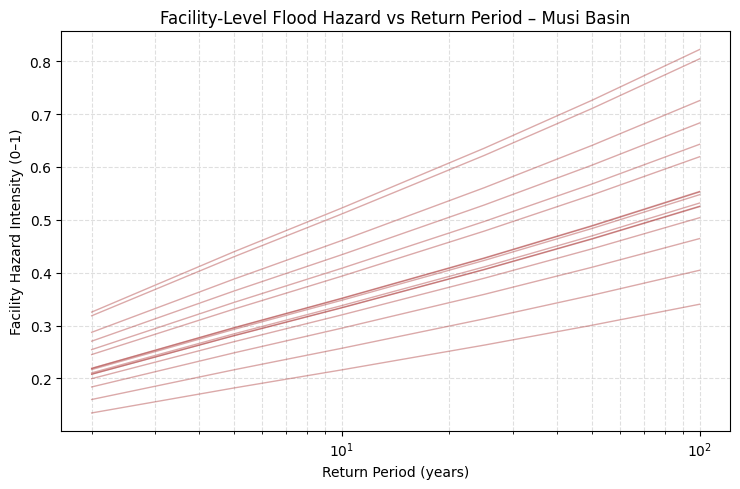

In [60]:
import matplotlib.pyplot as plt
import numpy as np

# ============================================================
# SELECT HAZARD COLUMNS
# ============================================================

rp_cols = [
    "hazard_2yr",
    "hazard_5yr",
    "hazard_10yr",
    "hazard_25yr",
    "hazard_50yr",
    "hazard_100yr"
]

return_periods = np.array([2, 5, 10, 25, 50, 100])

plt.figure(figsize=(7.5, 5))

for _, row in waste.iterrows():
    plt.plot(
        return_periods,
        row[rp_cols].values,
        color="brown",
        alpha=0.4,
        linewidth=1
    )

plt.xscale("log")
plt.xlabel("Return Period (years)")
plt.ylabel("Facility Hazard Intensity (0–1)")
plt.title("Facility-Level Flood Hazard vs Return Period – Musi Basin")

plt.grid(True, which="both", linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()


#### damage scenarios 

In [61]:
import geopandas as gpd
import numpy as np
import pandas as pd

# ============================================================
# LOAD FACILITY EVT HAZARD SCENARIOS
# ============================================================

waste = gpd.read_file(
    "/vol/sandeep_storage/Files2/catastrophe/osm/"
    "waste_facilities_flood_hazard_scenarios_evt.geojson"
).to_crs(epsg=4326)

print("Loaded facilities:", len(waste))

# ============================================================
# DEFINE VULNERABILITY (DAMAGE) CURVE PARAMETERS
# ============================================================

VULN_ALPHA = {
    "wastewater_plant": 1.3,
    "transfer_station": 1.6,
    "recycling": 1.8,
    "landfill": 2.0,
    "other": 2.2
}

DEFAULT_ALPHA = 2.0  # fallback

# ============================================================
# DAMAGE FUNCTION
# ============================================================

def damage_ratio(hazard, alpha):
    return np.clip(hazard ** alpha, 0, 1)

# ============================================================
# APPLY DAMAGE CURVES FOR EACH RETURN PERIOD
# ============================================================

rp_cols = [
    "hazard_2yr",
    "hazard_5yr",
    "hazard_10yr",
    "hazard_25yr",
    "hazard_50yr",
    "hazard_100yr"
]

for col in rp_cols:
    dr_col = col.replace("hazard_", "damage_")
    damage_vals = []

    for _, row in waste.iterrows():
        ftype = row["facility_type"]
        alpha = VULN_ALPHA.get(ftype, DEFAULT_ALPHA)
        damage_vals.append(
            damage_ratio(row[col], alpha)
        )

    waste[dr_col] = damage_vals

# ============================================================
# SANITY CHECK
# ============================================================

print("\nDamage ratio stats (100-year):")
print(waste["damage_100yr"].describe())

# ============================================================
# SAVE OUTPUT
# ============================================================

out_path = (
    "/vol/sandeep_storage/Files2/catastrophe/osm/"
    "waste_facilities_damage_scenarios_evt.geojson"
)

waste.to_file(out_path, driver="GeoJSON")

print("\nSaved facility-level damage scenarios:")
print(out_path)


Loaded facilities: 16

Damage ratio stats (100-year):
count    16.000000
mean      0.461946
std       0.160521
min       0.246271
25%       0.353846
50%       0.436223
75%       0.548312
max       0.775044
Name: damage_100yr, dtype: float64

Saved facility-level damage scenarios:
/vol/sandeep_storage/Files2/catastrophe/osm/waste_facilities_damage_scenarios_evt.geojson


In [62]:
waste


,facility_type,dist_to_drainage_m,vuln_drainage,elevation_m,elev_percentile,vuln_elevation,slope_deg,slope_percentile,vuln_slope,flood_hazard_index,...,hazard_25yr,hazard_50yr,hazard_100yr,geometry,damage_2yr,damage_5yr,damage_10yr,damage_25yr,damage_50yr,damage_100yr
0,wastewater_plant,1175.916986,0.764817,515.0,0.50000,0.50000,1.238635,0.93750,0.06250,0.531667,...,0.410891,0.469511,0.531667,POINT (78.46435 17.41619),0.131906,0.194998,0.243901,0.314662,0.374230,0.439878
1,wastewater_plant,159.951078,0.968010,502.0,0.25000,0.75000,0.699146,0.46875,0.53125,0.804354,...,0.621632,0.710318,0.804354,POINT (78.53388 17.3818),0.225951,0.334025,0.417795,0.539006,0.641045,0.753497
2,landfill,3187.375573,0.362525,495.0,0.12500,0.87500,0.972854,0.71875,0.28125,0.525636,...,0.406229,0.464184,0.525636,POINT (78.5822 17.35038),0.043316,0.079036,0.111517,0.165022,0.215467,0.276293
3,wastewater_plant,28.441820,0.994312,518.0,0.65625,0.34375,0.718740,0.62500,0.37500,0.642753,...,0.496741,0.567609,0.642753,POINT (78.57735 17.39818),0.168807,0.249548,0.312132,0.402688,0.478921,0.562934
4,transfer_station,168.646433,0.966271,528.0,0.93750,0.06250,0.448432,0.18750,0.81250,0.619197,...,0.478536,0.546807,0.619197,POINT (78.47969 17.41394),0.105475,0.170644,0.224752,0.307513,0.380658,0.464436
5,wastewater_plant,873.892710,0.825221,532.0,1.00000,0.00000,0.000000,0.09375,0.90625,0.552600,...,0.427068,0.487996,0.552600,POINT (78.47197 17.44359),0.138697,0.205036,0.256457,0.330861,0.393496,0.462523
6,wastewater_plant,303.693938,0.939261,526.0,0.87500,0.12500,0.984000,0.81250,0.18750,0.503918,...,0.389444,0.445005,0.503918,POINT (78.47839 17.43744),0.123027,0.181871,0.227483,0.293480,0.349039,0.410268
7,wastewater_plant,1211.262999,0.757747,493.0,0.06250,0.93750,0.972854,0.71875,0.28125,0.725361,...,0.560584,0.640560,0.725361,POINT (78.35948 17.41553),0.197539,0.292024,0.365260,0.471230,0.560438,0.658750
8,wastewater_plant,568.492664,0.886301,525.0,0.81250,0.18750,1.280363,1.00000,0.00000,0.464461,...,0.358951,0.410161,0.464461,POINT (78.5509 17.42333),0.110654,0.163580,0.204604,0.263964,0.313936,0.369006
9,landfill,2460.283916,0.507943,515.0,0.50000,0.50000,0.619390,0.25000,0.75000,0.553574,...,0.427821,0.488856,0.553574,POINT (78.37324 17.45976),0.048043,0.087662,0.123687,0.183031,0.238981,0.306445


#### Vulnerability (Damage) Curves by Facility Type

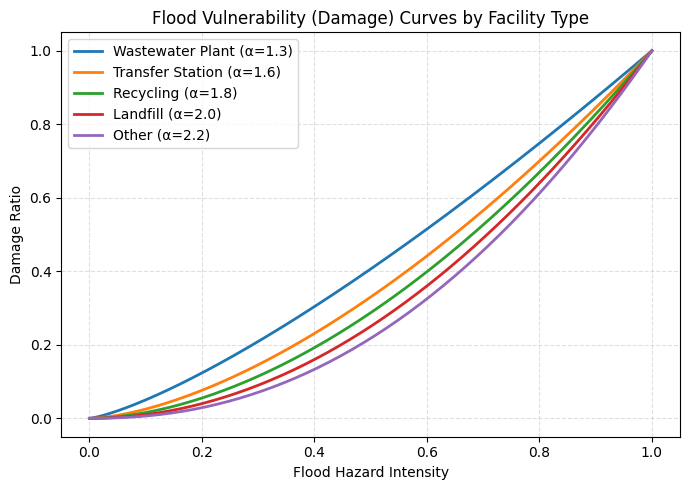

In [63]:
import numpy as np
import matplotlib.pyplot as plt

# ============================================================
# VULNERABILITY PARAMETERS
# ============================================================

VULN_ALPHA = {
    "wastewater_plant": 1.3,
    "transfer_station": 1.6,
    "recycling": 1.8,
    "landfill": 2.0,
    "other": 2.2
}

hazard = np.linspace(0, 1, 200)

plt.figure(figsize=(7, 5))

for ftype, alpha in VULN_ALPHA.items():
    damage = hazard ** alpha
    plt.plot(
        hazard,
        damage,
        linewidth=2,
        label=f"{ftype.replace('_',' ').title()} (α={alpha})"
    )

plt.xlabel("Flood Hazard Intensity")
plt.ylabel("Damage Ratio")
plt.title("Flood Vulnerability (Damage) Curves by Facility Type")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()


#### Event Damage vs Return Period (Portfolio View)

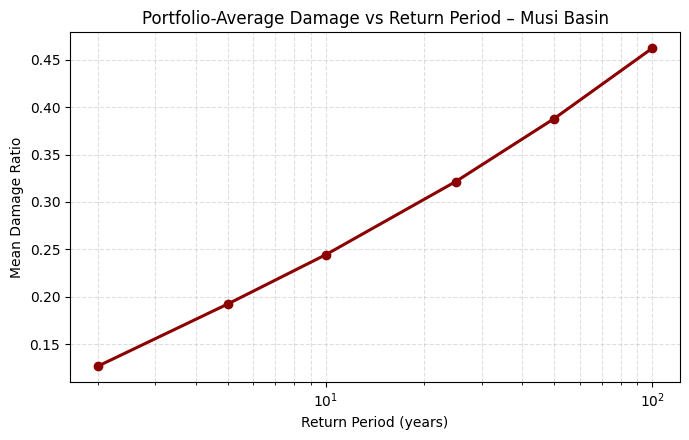

In [64]:
# ============================================================
# AGGREGATED DAMAGE PER EVENT
# ============================================================

damage_cols = [
    "damage_2yr",
    "damage_5yr",
    "damage_10yr",
    "damage_25yr",
    "damage_50yr",
    "damage_100yr"
]

mean_damage = waste[damage_cols].mean().values

plt.figure(figsize=(7, 4.5))

plt.plot(
    return_periods,
    mean_damage,
    marker="o",
    linewidth=2.2,
    color="darkred"
)

plt.xscale("log")
plt.xlabel("Return Period (years)")
plt.ylabel("Mean Damage Ratio")
plt.title("Portfolio-Average Damage vs Return Period – Musi Basin")

plt.grid(True, which="both", linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()


----